In [41]:
import numpy as np

import pandas as pd
import glob
import time
from natsort import natsorted

from maxij_nicerdefs import *

from scipy.signal import fftconvolve
import matplotlib
import matplotlib.pyplot as plt
from pylab import subplot, subplots_adjust, legend
%matplotlib inline

In [42]:
## user inputs:

# info for reading x-ray data (directory and filter for night)
# for example, for 3/28 the NICER date is 113
xpathnam = 'delivery/'
filename_filter = 'ni1200120113_0mpu7_silver_GTI*.lc' # for 3/28

# infor to read rho optical data (directory and night)
opathnam = './maxij_data_copies/'
night = '2018-03-28'

# computer clock is ~51.5s fast (per lab tests + SSE calculation)
# (((POSSIBLY 8.5 s slow, but this seems to work?)))
clocklag = -51.5 
# clocklag = 8.5
# clocklag -=60

In [43]:
## read in nicer xray data for night and make pandas df
# get filenames for night's xray data
ftest = xpathnam + filename_filter
flistD = glob.glob(ftest)

# all files
flist = [fnam.split('/')[1] for fnam in flistD]
flist = natsorted(flist)
# print len(flist)
ndat_t = []
ndat_cts = []
ndat_cts1 = []
ndat_cts2 = []
ndat_cts34 = []
ndat_fnam = []

for fileX in flist:
    t,cts=rd_nicer_lc(xpathnam,[fileX])
    t1,cts1=rd_nicer_lc1(xpathnam,[fileX])
    t2,cts2=rd_nicer_lc2(xpathnam,[fileX])
    t34,cts34=rd_nicer_lc34(xpathnam,[fileX])
    filename_column = [fileX for x in np.arange(len(t))]

    ndat_t.append(t)
    ndat_cts.append(cts)
    ndat_cts1.append(cts1)
    ndat_cts2.append(cts2)
    ndat_cts34.append(cts34)
    ndat_fnam.append(filename_column)

ndict = {'filename': [item for sublist in ndat_fnam for item in sublist],
          'time': [item for sublist in ndat_t for item in sublist],
          'cts': [item for sublist in ndat_cts for item in sublist],
          'cts1': [item for sublist in ndat_cts1 for item in sublist],
          'cts2': [item for sublist in ndat_cts2 for item in sublist],
          'cts34': [item for sublist in ndat_cts34 for item in sublist]
          }

nicerdata = pd.DataFrame(ndict, index=ndict['time'])
# print nicerdata

In [44]:
#read in optical data as pandas dataframe:
rhodata = pd.read_pickle(opathnam+'data_'+night+'.pkl')
# print data
print len(rhodata)
rhodata['fixed_time'] = rhodata['os_time'] + clocklag

11729


In [45]:
# do not change this! it is absolutely calibrated to the 28th.
# unix epoch timestamp - nicer absolute time
# both at 2018-03-28 08:05:21.000 UTC
dt = 1522224321-133689923
print dt
nicerdata['unix_time'] = nicerdata['time'] + dt

1388534398


In [46]:
t_startrho = np.min(rhodata['fixed_time'])
t_stoprho = np.max(rhodata['fixed_time'])
flist_overlap = []
# for each GTI:
i = 1
for fnam in flist:
    t = nicerdata.loc[nicerdata['filename']==fnam]['time']
    t_start = np.min(t) #t[0]
    t_start_unix = np.int(t_start + dt) #round down to the second

    t_stop = np.max(t)
    t_stop_unix = np.int(t_stop + dt)

    print "Time at beginning of Nicer GTI " + str(i)
    print str(t_start_unix) + " <-- unix epoch timestamp"
    print time.strftime('%m/%d/%Y %H:%M:%S',  time.gmtime(t_start_unix)) + " UTC"


    print "Time at end of GTI: " + time.strftime('%m/%d/%Y %H:%M:%S', time.gmtime(t_stop_unix)) + " UTC"

    print "Length of GTI: " + str(t_stop_unix - t_start_unix) + " seconds"

    if (t_start_unix >= t_startrho) and (t_stop_unix <= t_stoprho):
        print "GTI Overlaps with RHO data"
        flist_overlap.append(fnam)


    print
    i += 1

Time at beginning of Nicer GTI 1
1522224321 <-- unix epoch timestamp
03/28/2018 08:05:21 UTC
Time at end of GTI: 03/28/2018 08:08:25 UTC
Length of GTI: 184 seconds
GTI Overlaps with RHO data

Time at beginning of Nicer GTI 2
1522224555 <-- unix epoch timestamp
03/28/2018 08:09:15 UTC
Time at end of GTI: 03/28/2018 08:10:49 UTC
Length of GTI: 94 seconds
GTI Overlaps with RHO data

Time at beginning of Nicer GTI 3
1522224650 <-- unix epoch timestamp
03/28/2018 08:10:50 UTC
Time at end of GTI: 03/28/2018 08:12:52 UTC
Length of GTI: 122 seconds
GTI Overlaps with RHO data

Time at beginning of Nicer GTI 4
1522229995 <-- unix epoch timestamp
03/28/2018 09:39:55 UTC
Time at end of GTI: 03/28/2018 09:41:04 UTC
Length of GTI: 69 seconds
GTI Overlaps with RHO data

Time at beginning of Nicer GTI 5
1522230065 <-- unix epoch timestamp
03/28/2018 09:41:05 UTC
Time at end of GTI: 03/28/2018 09:43:07 UTC
Length of GTI: 122 seconds
GTI Overlaps with RHO data

Time at beginning of Nicer GTI 6
152223026

In [47]:
mar28a_nfiles = flist[0:3]
# mar28a_nfiles = flist[3:6] #mar28b
#
mar28a_nicerdata = nicerdata.loc[nicerdata['filename'].isin(mar28a_nfiles)]
mar28a_rhodata = rhodata.loc[(rhodata['fixed_time'] > np.floor(np.min(mar28a_nicerdata['unix_time']))) & (rhodata['fixed_time'] < np.ceil(np.max(mar28a_nicerdata['unix_time'])))]
print np.max(mar28a_nicerdata['unix_time']) - np.min(mar28a_nicerdata['unix_time'])
print np.max(mar28a_rhodata['fixed_time']) - np.min(mar28a_rhodata['fixed_time'])

xt = mar28a_nicerdata['unix_time']
xlc = mar28a_nicerdata['cts']
ot = mar28a_rhodata['fixed_time']
olc = mar28a_rhodata['phot_maxij']
tlc = mar28a_rhodata['phot_tyc']

451.746100903
450.880000114


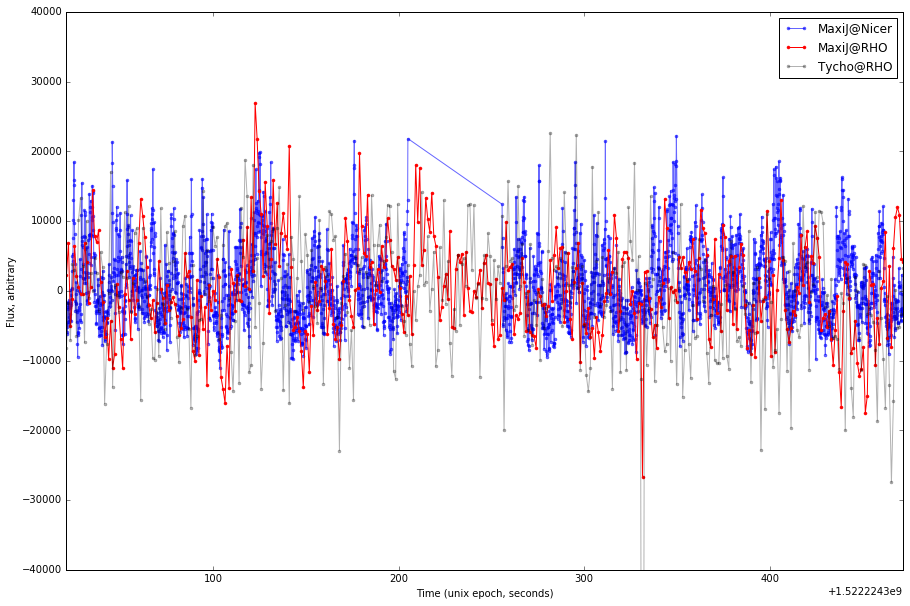

In [48]:
# %matplotlib qt
%matplotlib inline 
## full lightcurve plot for data part
fig1,ax=plt.subplots(figsize=[15,10],facecolor='w')

ax.plot(xt,xlc-np.median(xlc),'.-b',alpha=.6)
ax.plot(ot,olc-np.median(olc),'.-r')
ax.plot(ot,tlc-np.median(tlc),'.-k',alpha=.3)
# ax.plot(xt,xlc,'.-b')
# ax.plot(ot,olc,'.-r')
# ax.plot(ot,tlc,'.-k',alpha=.3)
ax.set_xlim(np.min(ot),np.max(ot))
ax.set_ylim(-40000,40000)
ax.legend(['MaxiJ@Nicer','MaxiJ@RHO',"Tycho@RHO"])
ax.set_xlabel('Time (unix epoch, seconds)')
ax.set_ylabel('Flux, arbitrary')
# # plt.show()

In [49]:
t = np.arange(np.floor(np.min(mar28a_nicerdata['unix_time'])),np.ceil(np.max(mar28a_nicerdata['unix_time'])))
tyc_min = 300000.
# xts = make_1s_ts(t, np.array(xt),np.array(xlc)-np.median(xlc))
# ots = make_1s_ts(t, np.array(ot[tlc>tyc_min]),np.array(olc[tlc>tyc_min])-np.median(olc[tlc>tyc_min]))
# tts = make_1s_ts(t, np.array(ot[tlc>tyc_min]),np.array(tlc[tlc>tyc_min])-np.median(tlc[tlc>tyc_min]))
xts = make_1s_ts(t, np.array(xt),np.array(xlc))
ots = make_1s_ts(t, np.array(ot[tlc>tyc_min]),np.array(olc[tlc>tyc_min]))
tts = make_1s_ts(t, np.array(ot[tlc>tyc_min]),np.array(tlc[tlc>tyc_min]))

print len(t), len(ots)

452 452


In [50]:
ntot = 64
xts_c = chunks(xts,ntot)
ots_c = chunks(ots,ntot)
tts_c = chunks(tts,ntot)
tc = np.arange(ntot)
# print xts_c
print "number of 128s chunks: " + str(len(xts_c))
ctot = len(xts_c)

print np.shape(xts_c)
xts_cm = np.zeros(np.shape(xts_c))
ots_cm = np.zeros(np.shape(ots_c))
tts_cm = np.zeros(np.shape(tts_c))
for c in xrange(ctot): 
    xts_m = np.median(xts_c[c][xts_c[c]>0])
    ots_m = np.median(ots_c[c][ots_c[c]>0])
    tts_m = np.median(tts_c[c][tts_c[c]>0])
    for i in xrange(ntot): 
        if xts_c[c][i] > 0: 
            xts_cm[c][i] = xts_c[c][i]-xts_m
        if ots_c[c][i] > 0: 
            ots_cm[c][i] = ots_c[c][i]-ots_m
        if tts_c[c][i] > 0: 
            tts_cm[c][i] = tts_c[c][i]-tts_m


number of 128s chunks: 8
(8, 64)


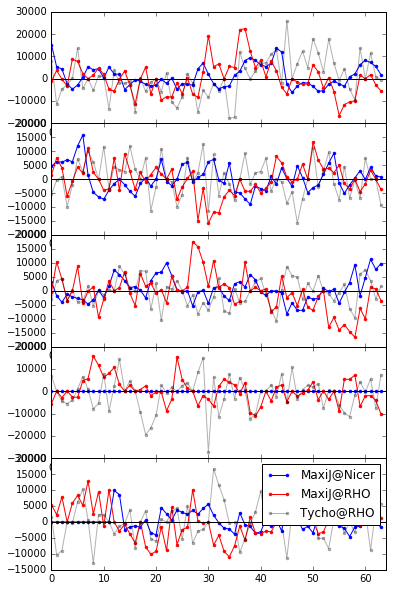

In [76]:
# plot of time series over chunk of data
fig2,ax1=plt.subplots(figsize=[6,10],facecolor='w')
subplots_adjust(hspace=0.000)
for c,v in enumerate(xrange(ctot)):
    v = v+1
    ax1 = subplot(ctot,1,v)
    ax1.plot(tc, xts_cm[c],'.-b')
    ax1.plot(tc, ots_cm[c],'.-r')
    ax1.plot(tc, tts_cm[c],'.-k',alpha=.3)
#     ax1.plot(tc, xts_c[c]-np.median(xts_c[c]),'.-b')
#     ax1.plot(tc[ots_cm[c]>0], ots_c[c][ots_c[c]>0]-np.median(ots_c),'.-r')
#     ax1.plot(tc[tts_c[c]>0], tts_c[c][tts_c[c]>0]-np.median(tts_c),'.-k',alpha=.3)
    ax1.plot([0,ntot],[0,0],'k')
    ax1.set_xlim(0,ntot)
ax1.legend(['MaxiJ@Nicer','MaxiJ@RHO',"Tycho@RHO"])

In [52]:
## to get power spectra:
# tf=np.arange(len(t))
# fx,px,pxtot = pds_chunk128(tf,xts,0,np.max(tf))
# fo,po,potot = pds_chunk128(tf,ots,0,np.max(tf))

In [53]:
# to get cross corrl'ns:
auto_x = []
auto_o = []
auto_t = []

crosscorr_xo = []
crosscorr_xt = []
crosscorr_ot = []

for c in xrange(ctot):
    auto_x.append(fftconvolve(xts_cm[c],xts_cm[c][::-1],mode='same')) #x-ray autocorrelation
    auto_o.append(fftconvolve(ots_cm[c],ots_cm[c][::-1],mode='same')) #optical autocorrelation
    auto_t.append(fftconvolve(tts_cm[c],tts_cm[c][::-1],mode='same')) #tycho reference star autocorrelation

    crosscorr_xo.append(fftconvolve(xts_cm[c],ots_cm[c][::-1],mode='same')) # cross correlation
    crosscorr_xt.append(fftconvolve(xts_cm[c],tts_cm[c][::-1],mode='same')) # cross corr'ln w/ refstar
    crosscorr_ot.append(fftconvolve(ots_cm[c],tts_cm[c][::-1],mode='same'))


32


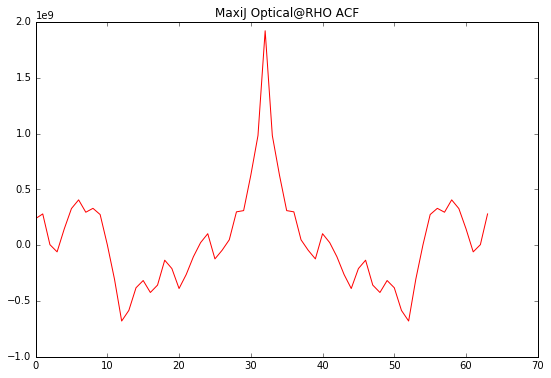

In [54]:
#plot auto correlations
fig3,ax=plt.subplots(figsize=[9,6],facecolor='w')
# ax.plot(auto_x[0],'b')
ax.plot(auto_o[0],'r')
# ax.plot(auto_t[0],'k')
# ax.plot([63.,63.],[0,3.e29],'y',alpha=.7)
# ax.set_ylim(0,9e24)
# ax.set_xlim(40,80)
# print np.argmax(auto_x)
print np.argmax(auto_o[0])
plt.title('MaxiJ Optical@RHO ACF')
# # plt.show()

26


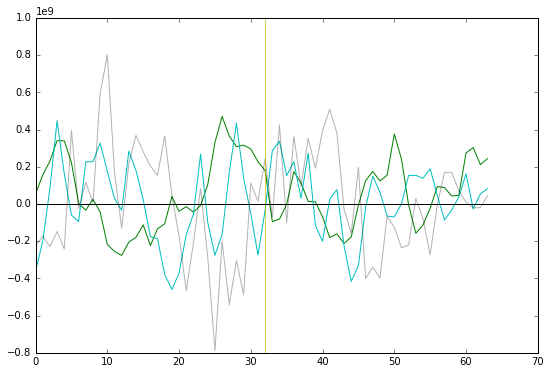

In [55]:
c = 0
#plot cross correlations
fig3,ax=plt.subplots(figsize=[9,6],facecolor='w')
ax.plot(crosscorr_xo[c],'g')
ax.plot(crosscorr_xt[c],'c')
ax.plot(crosscorr_ot[c],'k',alpha=.3)
ax.axvline(x=ntot/2.,color='y',alpha=.7)
ax.axhline(y=0,color='k')
# ax.set_ylim(-2e9,2e9)
# ax.set_xlim(40,80)
# print np.argmax(auto_x)
print np.argmax(crosscorr_xo[c])
# # plt.show()

26


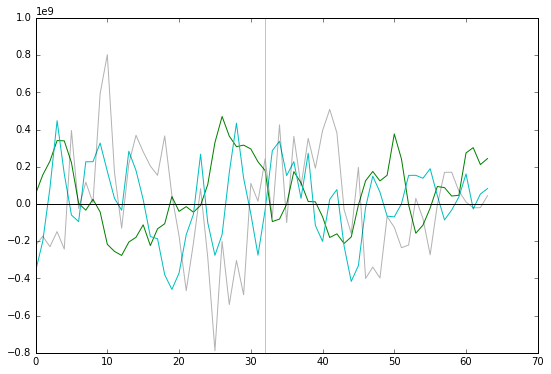

In [56]:
#plot cross correlations
fig3,ax=plt.subplots(figsize=[9,6])
ax.plot(crosscorr_xo[0],'g')
ax.plot(crosscorr_xt[0],'c')
ax.plot(crosscorr_ot[0],'k',alpha=.3)
ax.axvline(x=ntot/2.,color='y',alpha=.7)
ax.axhline(y=0,color='k')
# ax.set_ylim(0,9e24)
# ax.set_xlim(40,80)
# print np.argmax(auto_x)
print np.argmax(crosscorr_xo[0])
# # plt.show()

In [57]:
# bxo = [crosscorr_xo[2],crosscorr_xo[6]]
# bxt = [crosscorr_xt[2],crosscorr_xt[6]]
# bot = [crosscorr_ot[2],crosscorr_ot[6]]

axo = [crosscorr_xo[0],crosscorr_xo[1],crosscorr_xo[2]]
axt = [crosscorr_xt[0],crosscorr_xt[1],crosscorr_xt[2]]
aot = [crosscorr_ot[0],crosscorr_ot[1],crosscorr_ot[2]]

In [58]:
# mar28a_nfiles = flist[0:3]
mar28a_nfiles = flist[3:6] #mar28b
#
mar28a_nicerdata = nicerdata.loc[nicerdata['filename'].isin(mar28a_nfiles)]
mar28a_rhodata = rhodata.loc[(rhodata['fixed_time'] > np.floor(np.min(mar28a_nicerdata['unix_time']))) & (rhodata['fixed_time'] < np.ceil(np.max(mar28a_nicerdata['unix_time'])))]
print np.max(mar28a_nicerdata['unix_time']) - np.min(mar28a_nicerdata['unix_time'])
print np.max(mar28a_rhodata['fixed_time']) - np.min(mar28a_rhodata['fixed_time'])

xt = mar28a_nicerdata['unix_time']
xlc = mar28a_nicerdata['cts']
ot = mar28a_rhodata['fixed_time']
olc = mar28a_rhodata['phot_maxij']
tlc = mar28a_rhodata['phot_tyc']

473.861401558
473.589999914


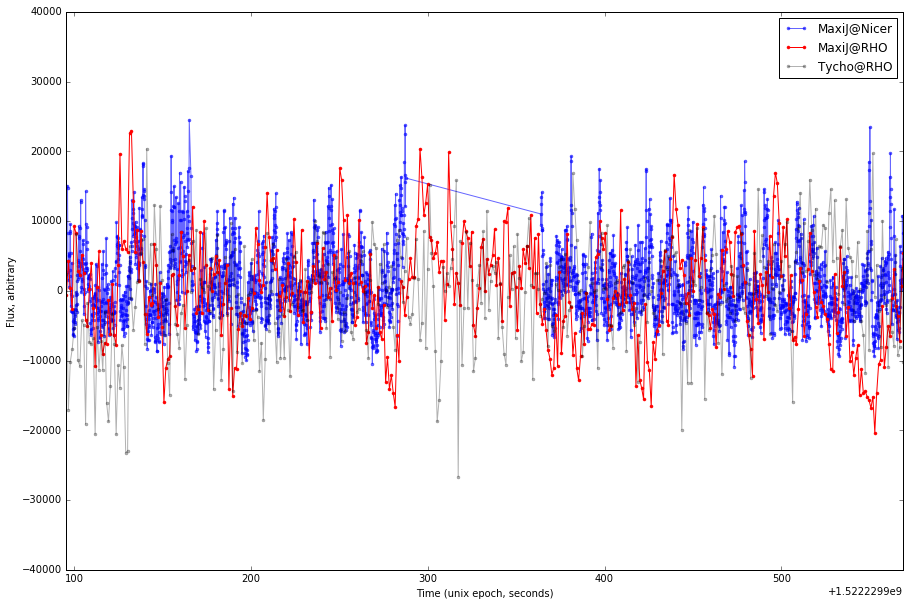

In [59]:
# %matplotlib qt
%matplotlib inline 
## full lightcurve plot for data part
fig1,ax=plt.subplots(figsize=[15,10],facecolor='w')

ax.plot(xt,xlc-np.median(xlc),'.-b',alpha=.6)
ax.plot(ot,olc-np.median(olc),'.-r')
ax.plot(ot,tlc-np.median(tlc),'.-k',alpha=.3)
# ax.plot(xt,xlc,'.-b')
# ax.plot(ot,olc,'.-r')
# ax.plot(ot,tlc,'.-k',alpha=.3)
ax.set_xlim(np.min(ot),np.max(ot))
ax.set_ylim(-40000,40000)
ax.legend(['MaxiJ@Nicer','MaxiJ@RHO',"Tycho@RHO"])
ax.set_xlabel('Time (unix epoch, seconds)')
ax.set_ylabel('Flux, arbitrary')
# # plt.show()

In [60]:
t = np.arange(np.floor(np.min(mar28a_nicerdata['unix_time'])),np.ceil(np.max(mar28a_nicerdata['unix_time'])))
tyc_min = 300000.
# xts = make_1s_ts(t, np.array(xt),np.array(xlc)-np.median(xlc))
# ots = make_1s_ts(t, np.array(ot[tlc>tyc_min]),np.array(olc[tlc>tyc_min])-np.median(olc[tlc>tyc_min]))
# tts = make_1s_ts(t, np.array(ot[tlc>tyc_min]),np.array(tlc[tlc>tyc_min])-np.median(tlc[tlc>tyc_min]))
xts = make_1s_ts(t, np.array(xt),np.array(xlc))
ots = make_1s_ts(t, np.array(ot[tlc>tyc_min]),np.array(olc[tlc>tyc_min]))
tts = make_1s_ts(t, np.array(ot[tlc>tyc_min]),np.array(tlc[tlc>tyc_min]))

print len(t), len(ots)

475 475


In [61]:
ntot = 64
xts_c = chunks(xts,ntot)
ots_c = chunks(ots,ntot)
tts_c = chunks(tts,ntot)
tc = np.arange(ntot)
# print xts_c
print "number of 128s chunks: " + str(len(xts_c))
ctot = len(xts_c)

print np.shape(xts_c)
xts_cm = np.zeros(np.shape(xts_c))
ots_cm = np.zeros(np.shape(ots_c))
tts_cm = np.zeros(np.shape(tts_c))
for c in xrange(ctot): 
    xts_m = np.median(xts_c[c][xts_c[c]>0])
    ots_m = np.median(ots_c[c][ots_c[c]>0])
    tts_m = np.median(tts_c[c][tts_c[c]>0])
    for i in xrange(ntot): 
        if xts_c[c][i] > 0: 
            xts_cm[c][i] = xts_c[c][i]-xts_m
        if ots_c[c][i] > 0: 
            ots_cm[c][i] = ots_c[c][i]-ots_m
        if tts_c[c][i] > 0: 
            tts_cm[c][i] = tts_c[c][i]-tts_m


number of 128s chunks: 8
(8, 64)


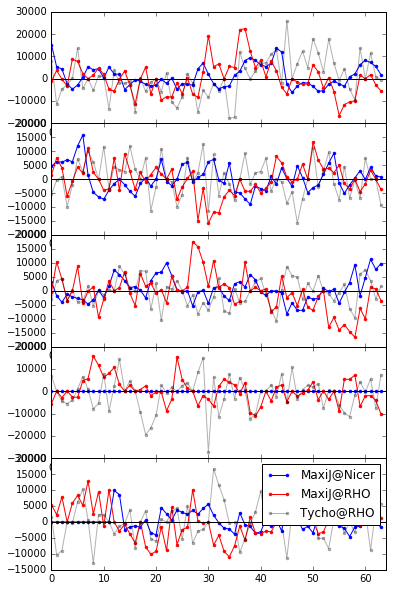

In [77]:
# plot of time series over chunk of data
fig2,ax1=plt.subplots(figsize=[6,10],facecolor='w')
subplots_adjust(hspace=0.000)
for c,v in enumerate(xrange(ctot)):
    v = v+1
    ax1 = subplot(ctot,1,v)
    ax1.plot(tc, xts_cm[c],'.-b')
    ax1.plot(tc, ots_cm[c],'.-r')
    ax1.plot(tc, tts_cm[c],'.-k',alpha=.3)
#     ax1.plot(tc, xts_c[c]-np.median(xts_c[c]),'.-b')
#     ax1.plot(tc[ots_cm[c]>0], ots_c[c][ots_c[c]>0]-np.median(ots_c),'.-r')
#     ax1.plot(tc[tts_c[c]>0], tts_c[c][tts_c[c]>0]-np.median(tts_c),'.-k',alpha=.3)
    ax1.plot([0,ntot],[0,0],'k')
    ax1.set_xlim(0,ntot)
ax1.legend(['MaxiJ@Nicer','MaxiJ@RHO',"Tycho@RHO"])

In [63]:
## to get power spectra:
# tf=np.arange(len(t))
# fx,px,pxtot = pds_chunk128(tf,xts,0,np.max(tf))
# fo,po,potot = pds_chunk128(tf,ots,0,np.max(tf))

In [64]:
# to get cross corrl'ns:
auto_x = []
auto_o = []
auto_t = []

crosscorr_xo = []
crosscorr_xt = []
crosscorr_ot = []

for c in xrange(ctot):
    auto_x.append(fftconvolve(xts_cm[c],xts_cm[c][::-1],mode='same')) #x-ray autocorrelation
    auto_o.append(fftconvolve(ots_cm[c],ots_cm[c][::-1],mode='same')) #optical autocorrelation
    auto_t.append(fftconvolve(tts_cm[c],tts_cm[c][::-1],mode='same')) #tycho reference star autocorrelation

    crosscorr_xo.append(fftconvolve(xts_cm[c],ots_cm[c][::-1],mode='same')) # cross correlation
    crosscorr_xt.append(fftconvolve(xts_cm[c],tts_cm[c][::-1],mode='same')) # cross corr'ln w/ refstar
    crosscorr_ot.append(fftconvolve(ots_cm[c],tts_cm[c][::-1],mode='same'))


32


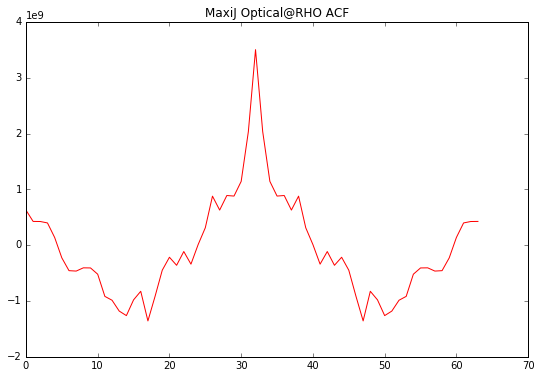

In [65]:
#plot auto correlations
fig3,ax=plt.subplots(figsize=[9,6],facecolor='w')
# ax.plot(auto_x[0],'b')
ax.plot(auto_o[0],'r')
# ax.plot(auto_t[0],'k')
# ax.plot([63.,63.],[0,3.e29],'y',alpha=.7)
# ax.set_ylim(0,9e24)
# ax.set_xlim(40,80)
# print np.argmax(auto_x)
print np.argmax(auto_o[0])
plt.title('MaxiJ Optical@RHO ACF')
# # plt.show()

0


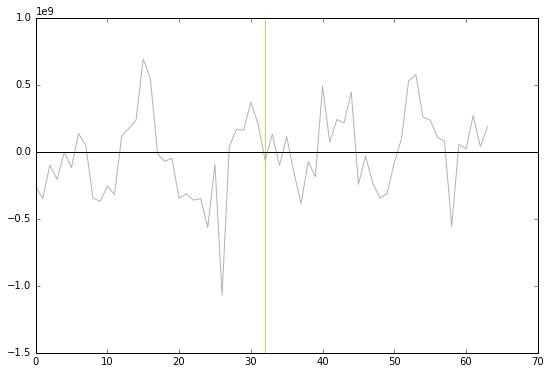

In [84]:
c = 3
#plot cross correlations
fig3,ax=plt.subplots(figsize=[9,6],facecolor='w')
ax.plot(crosscorr_xo[c],'g')
ax.plot(crosscorr_xt[c],'c')
ax.plot(crosscorr_ot[c],'k',alpha=.3)
ax.axvline(x=ntot/2.,color='y',alpha=.7)
ax.axhline(y=0,color='k')
# ax.set_ylim(-2e9,2e9)
# ax.set_xlim(40,80)
# print np.argmax(auto_x)
print np.argmax(crosscorr_xo[c])
# # plt.show()

In [ ]:
# fig10,ax=plt.subplots(figsize=[8,6],facecolor='w')
# subplots_adjust(hspace=0.1000)
# ctot = len(goodxo)
# fig10.tight_layout()
# fig10.subplots_adjust(top=.95)
# fig10.suptitle('CCFs of 5 best (by-eye) chunks of 64-second data',fontsize=16)

# for c,v in enumerate(xrange(ctot)):
#     v = v+1
#     ax = subplot(ctot,1,v)
#     ax.plot(goodxo[c],'g',linewidth=2)
#     ax.plot(goodxt[c],'c', linewidth=2)
#     ax.plot(goodot[c], 'm',alpha=.3, linewidth=2)
#     ax.axvline(x=ntot/2.,color='y',alpha=.7)
#     ax.axhline(y=0,color='k')
# # ax.plot(crosscorr_xo - crosscorr_xt,'k')
# # ax.plot(auto_o/4,'r')
# # ax.plot(auto_x,'b')
# # ax.plot(auto_t/3,'k')
# #     ax.plot([np.argmax(auto_x),np.argmax(auto_x)],[-4.e9,2.e10],'y',alpha=.7)
# #     ax.set_ylim(-2.5e9,2.5e9)
#     ax.set_xlim(0,ntot)
# #     ax.set_xlim(20,40)

# # ax.set_title('Optical+X-ray Correlation (one chunk of 128-second overlapping data) 51.5s lead')
# ax.legend(['MaxiJ@Nicer/MaxiJ@RHO',
#            'MaxiJ@Nicer/Tycho@RHO',
#            'MaxiJ@RHO/Tycho@RHO',
#            # 'RHO Optical Auto-correlation',
#            # 'Nicer X-ray Auto-correlation',
#            # 'RHO Tycho Reference Auto-correlation',
# #            'Autocorrelation Peak'
#           ],
#          loc='upper center', bbox_to_anchor=(0.5, -0.05),
#           fancybox=True, shadow=True, ncol=3)

# print np.argmax(crosscorr_xo)

39


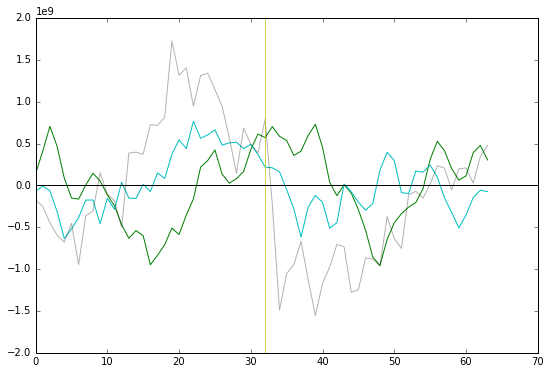

In [67]:
#plot cross correlations
fig3,ax=plt.subplots(figsize=[9,6])
ax.plot(crosscorr_xo[0],'g')
ax.plot(crosscorr_xt[0],'c')
ax.plot(crosscorr_ot[0],'k',alpha=.3)
ax.axvline(x=ntot/2.,color='y',alpha=.7)
ax.axhline(y=0,color='k')
# ax.set_ylim(0,9e24)
# ax.set_xlim(40,80)
# print np.argmax(auto_x)
print np.argmax(crosscorr_xo[0])
# # plt.show()

In [68]:
bxo = [crosscorr_xo[2],crosscorr_xo[6]]
bxt = [crosscorr_xt[2],crosscorr_xt[6]]
bot = [crosscorr_ot[2],crosscorr_ot[6]]

# axo = [crosscorr_xo[0],crosscorr_xo[1],crosscorr_xo[2]]
# axt = [crosscorr_xt[0],crosscorr_xt[1],crosscorr_xt[2]]
# aot = [crosscorr_ot[0],crosscorr_ot[1],crosscorr_ot[2]]

In [69]:
goodxo = axo+bxo
goodxt = axt+bxt
goodot = aot+bot

26


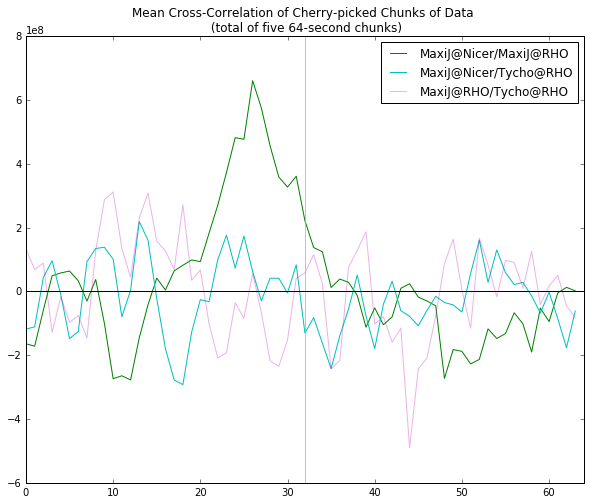

In [70]:
#plot cross correlations
fig3,ax=plt.subplots(figsize=[10,8],facecolor='w')
ax.plot(np.mean(goodxo,axis=0),'g')
ax.plot(np.mean(goodxt,axis=0),'c')
ax.plot(np.mean(goodot,axis=0),'m',alpha=.3)
ax.axvline(x=ntot/2.,color='y',alpha=.7)
ax.axhline(y=0,color='k')
ax.legend(['MaxiJ@Nicer/MaxiJ@RHO','MaxiJ@Nicer/Tycho@RHO','MaxiJ@RHO/Tycho@RHO'])
ax.set_title('Mean Cross-Correlation of Cherry-picked Chunks of Data \n (total of five 64-second chunks)')
ax.set_xlim(0,ntot)
print np.argmax(np.mean(goodxo,axis=0))


In [71]:
# fig3,ax1=plt.subplots(figsize=[15,15],facecolor='w')
# subplots_adjust(hspace=0.000)
# for c,v in enumerate(xrange(ctot)):
#     v = v+1
#     ax1 = subplot(ctot,1,v)
# #     ax1.plot(auto_x[c],'b')
# #     ax1.plot(auto_o[c],'r')
#     ax1.plot(auto_t[c],'k')
# #     ax1.plot([0,128],[0,0],'k')
# #     ax1.set_xlim(0,128)
# ax1.legend(['MaxiJ@Nicer','MaxiJ@RHO',"Tycho@RHO"])

152


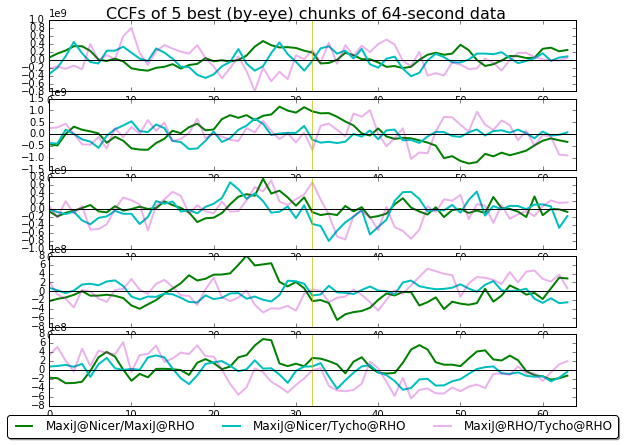

In [82]:
fig10,ax=plt.subplots(figsize=[8,6],facecolor='w')
subplots_adjust(hspace=0.1000)
ctot = len(goodxo)
fig10.tight_layout()
fig10.subplots_adjust(top=.95)
fig10.suptitle('CCFs of 5 best (by-eye) chunks of 64-second data',fontsize=16)

for c,v in enumerate(xrange(ctot)):
    v = v+1
    ax = subplot(ctot,1,v)
    ax.plot(goodxo[c],'g',linewidth=2)
    ax.plot(goodxt[c],'c', linewidth=2)
    ax.plot(goodot[c], 'm',alpha=.3, linewidth=2)
    ax.axvline(x=ntot/2.,color='y',alpha=.7)
    ax.axhline(y=0,color='k')
# ax.plot(crosscorr_xo - crosscorr_xt,'k')
# ax.plot(auto_o/4,'r')
# ax.plot(auto_x,'b')
# ax.plot(auto_t/3,'k')
#     ax.plot([np.argmax(auto_x),np.argmax(auto_x)],[-4.e9,2.e10],'y',alpha=.7)
#     ax.set_ylim(-2.5e9,2.5e9)
    ax.set_xlim(0,ntot)
#     ax.set_xlim(20,40)

# ax.set_title('Optical+X-ray Correlation (one chunk of 128-second overlapping data) 51.5s lead')
ax.legend(['MaxiJ@Nicer/MaxiJ@RHO',
           'MaxiJ@Nicer/Tycho@RHO',
           'MaxiJ@RHO/Tycho@RHO',
           # 'RHO Optical Auto-correlation',
           # 'Nicer X-ray Auto-correlation',
           # 'RHO Tycho Reference Auto-correlation',
#            'Autocorrelation Peak'
          ],
         loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3)

print np.argmax(crosscorr_xo)

In [73]:
# 
# fig5,ax=plt.subplots(figsize=[9,6])
# ax.plot(crosscorr_xo[0],'g')
# ax.plot([64,64],[.7e11,1.6e11])

In [74]:
(((4./(24.*365.))**2*10)**(1./3.))*500.

6.3876423918436815